<img src="pic\11.jpg" width="500"/>

注意，输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1， 而卷积核只与图像中每个大小完全适合的位置进行互相关运算。 所以，输出大小等于输入大小NhxNw减去卷积核大小KhxKw，即：

<img src="pic\12.jpg" width="500"/>

In [29]:
import torch
from PIL import Image
import numpy as np

# 手写卷积层

In [30]:
def cov2(x,k):
    '''计算二维相关运算'''
    h,w=k.shape  #卷积核的大小，高和宽
    y=torch.zeros((x.shape[0]-h+1,x.shape[1]-w+1))
    '''双层循环，步长设为1'''
    for i in range(y.shape[0]):  #长
        for j in range(y.shape[1]):  #宽
            y[i,j]=(x[i:i+h,j:j+w]*k).sum()
    return y

In [31]:
class conv2D(torch.nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight=torch.nn.Parameter(torch.rand(kernel_size)),
        self.bias=torch.nn.Parameter(torch.zeros(1))

    def forward(self,x,kernel):
        return cov2(x,kernel)+torch.tensor(self.bias)


In [48]:
x=torch.tensor([[1,2,3],[3,4,5],[5,6,7]]) #图片
kernel=torch.tensor([[0,1],[3,4]])  #卷积核
net=conv2D((kernel.shape[0],kernel.shape[1]))
net.forward(x,kernel)

C:\Users\jie'jie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([[27., 35.],
        [43., 51.]])

# 图像中目标的边缘检测
如下是卷积层的一个简单应用：通过找到像素变化的位置，来检测图像中不同颜色的边缘。 首先，我们构造一个6x8像素的黑白图像。中间四列为黑色（1），其余像素为白色（0）

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


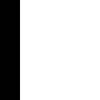

In [49]:
x=torch.ones((100,100))
x[:,20:]=0
print(x)
pic1=Image.fromarray(np.uint8(255 -x* 255))
pic1

接下来，我们构造一个高度为1、宽度2为的卷积核kernel。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。

In [50]:
kernel=torch.tensor([[1,-1]],)
kernel,kernel.shape

(tensor([[ 1, -1]]), torch.Size([1, 2]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([100, 99])


C:\Users\jie'jie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


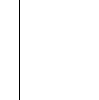

In [51]:
net=conv2D((kernel.shape[0],kernel.shape[1]))
bian_image=net.forward(x,kernel)
print(bian_image)
print(bian_image.shape)
'''矩阵转图片'''
bian_image=bian_image.numpy()
pic1=Image.fromarray(np.uint8(255 - bian_image* 255))
pic1

现在我们将输入的二维图像转置，再进行如上的互相关运算。 其输出如下，之前检测到的垂直边缘消失了。 不出所料，这个卷积核K只可以检测垂直边缘，无法检测水平边缘。

In [40]:
#net=conv2D((kernel.shape[0],kernel.shape[1]))
#bian_image=net.forward(x.t(),kernel)
#bian_image,bian_image.shape

# 学习卷积核
    如果我们只需寻找黑白边缘，那么以上[1, -1]的边缘检测器足以。然而，当有了更复杂数值的卷积核，或者连续的卷积层时，我们不可能手动设计滤波器。那么我们是否可以学习由X生成Y的卷积核呢？
现在让我们看看是否可以通过仅查看“输入-输出”对来学习由X生成Y的卷积核。 我们先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们比较Y与卷积层输出的平方误差，然后计算梯度来更新卷积核。为了简单起见，我们在此使用内置的二维卷积层，并忽略偏置。

In [56]:
x=torch.ones((6,8))
x[:,2:6]=0
kernel=torch.tensor([[1,-1]])
net=conv2D((kernel.shape[0],kernel.shape[1]))
bian_image=net.forward(x,kernel)
x,kernel,x.shape,bian_image.shape,kernel.shape

C:\Users\jie'jie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.]]),
 tensor([[ 1, -1]]),
 torch.Size([6, 8]),
 torch.Size([6, 7]),
 torch.Size([1, 2]))

In [57]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = torch.nn.Conv2d(1,1,kernel_size=(1, 2),bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1

x = x.reshape((1, 1, 6,8))
y = bian_image.reshape((1, 1, 6,7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(x)  #输出值
    l = (Y_hat - y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 2.789
epoch 4, loss 0.778
epoch 6, loss 0.258
epoch 8, loss 0.095
epoch 10, loss 0.037


In [58]:
conv2d.weight.data.reshape((1,2)),kernel

(tensor([[ 0.9740, -1.0132]]), tensor([[ 1, -1]]))